# Constructing a feed-forward neural network

In [77]:
import numpy as np

Having spent spent some time working on the implementation of supervised learning and getting familiar with the terminology of neural networks, let's write some code to implement a neural network from scratch. We're going to use a functional programming style to help build intuition. To make matters easier, we'll use a dictionary called `model` to store all data associated with the neural network (the weight matrices, the  bias vectors, etc.) and pass that into functions as a single argument. Production codes usually use an object-oriented style to  build networks and, of course, are optimized for efficiency (unlike what we'll develop here).

We're going to borrow notation from Michael Neilsen's [*Neural Networks and Deep Learning*](http://neuralnetworksanddeeplearning.com) to make life easier. In particular, we'll let $W^\ell$ and $b^\ell$ denote the weight matrices associated with the $\ell$th layer of the network. The entry $W^{\ell}_{jk}$ of $W^\ell$ is the weight parameter associated with the link connecting the $k$th neuron in layer $\ell-1$ to the $j$th neuron in layer $\ell$:

[![](img/tikz16.png)](http://neuralnetworksanddeeplearning.com/chap2.html)

## 1. Create an initialization function to set up model

Rather than the fixed constants in `setup` from before, write a function `initialize_model` that accepts a list  `dimensions` of positive integer inputs that constructs a `dict` with specific key-value pairs:
+ `model['nlayers']` : number of layers in neural network
+ `model['weights']` : list of NumPy matrices with appropriate dimensions
+ `model['biases']` : list of NumPy (column) vectors of appropriate dimensions

lists `weights` and `biases` with weight matrices and bias vectors of appropriate dimensions as input.

In [78]:
def initialize_model(dimensions):
    '''Accepts a list of positive integers; returns a dict 'model' with key/values as follows:
      model['nlayers'] : number of layers in neural network
      model['weights'] : list of NumPy matrices with appropriate dimensions
      model['biases'] : list of NumPy (column) vectors of appropriate dimensions
    These correspond to the weight matrices & bias vectors associated with each layer of a neural network.'''
    weights, biases = [], []
    L = len(dimensions) - 1 # number of layers (i.e., excludes input layer)
    for l in range(L):
        W = np.random.randn(dimensions[l+1], dimensions[l])
        b = np.random.randn(dimensions[l+1], 1)
        weights.append(W)
        biases.append(b)
    return dict(weights=weights, biases=biases, nlayers=L)

In [79]:
# Example to verify the preceding:
# For MNIST, consider dimensions = [28*28, 15, 10]
dimensions = [28*28, 15, 10]
model = initialize_model(dimensions)
for k, (W, b) in enumerate(zip(model['weights'], model['biases'])):
    print(f'Layer {k+1}:\tShape of W{k+1}: {W.shape}\tShape of b{k+1}: {b.shape}')

Layer 1:	Shape of W1: (15, 784)	Shape of b1: (15, 1)
Layer 2:	Shape of W2: (10, 15)	Shape of b2: (10, 1)


## 2. Implement activation function(s), loss functions, & their derivatives
For today's purposes, we'll use only the *logistic* or *sigmoid* function as an activation function:
$$ \sigma(x) = \frac{1}{1+\exp(-x)} = \frac{\exp(x)}{1+\exp(x)}.$$
A bit of calculus shows that that
$$ \sigma'(x) = \sigma(x)(1-\sigma(x)) .$$
Later, we'll see how PyTorch lets us use different ones. For the loss function, we'll use the typical "$L_2$-norm of the error" (alternatively called *mean-square error (MSE)* when averaged over a batch of values:
$$ \mathcal{E}(\hat{y},y) = \frac{1}{2} \|\hat{y}-y\|^{2} = \frac{1}{2} \sum_{k=1}^{d} \left[ \hat{y}_{k}-y_{k} \right]^{2}.$$
Again, using multivariable calculus, we can see that
$$\nabla \mathcal{E}(\hat{y},y) = \hat{y} - y.$$

In [80]:
def g(x):
    '''The logistic function; accepts arbitrary arrays as input (vectorized)'''
    return 1.0 / (1.0 + np.exp(-x))  # naive logistic function implementation
def g_prime(x):
    '''The *derivative* of the logistic function; accepts arbitrary arrays as input (vectorized)'''
    return g(x)*(1-g(x)) # Derivative of logistic function

def loss(yhat, y):
    '''The loss as measured by the L2-norm squared of the error'''
    return 0.5 * np.square(yhat-y).sum()
def loss_prime(yhat, y):
    '''Implementation of the gradient of the loss function'''
    return (yhat - y) # gradient w.r.t. yhat

## 3. Implement a function for forward propagation

Write a function `forward` that uses the architecture described in a `dict` as created by `initialize_model` to evaluate the output of the neural network for a given input *column* vector `x`.
+ Take $a^{0}=x$ from the input.
+ For $\ell=1,\dotsc,L$, compute & store the intermediate computed vectors $z^{\ell}=W^{\ell}a^{\ell-1}+b^{\ell}$ (the *weighted inputs*) and $a^{\ell}=\sigma\left(z^{\ell}\right)$ (the *activations*) in an updated dictionary `model`. That is, modify the input dictionary `model` so as to accumulate:
  + `model['activations']`: a list with entries $a^{\ell}$ for $\ell=0,\dotsc,L$
  + `model['z_inputs']`: a list with entries $z^{\ell}$ for $\ell=1,\dotsc,L$
+ The function should return the computed output $a^{L}$ and the modified dictionary `model`.

In [81]:
# Abstract process into function and run tests again.
def forward(x, model):
    '''Implementation of forward propagation'''
    a = x
    activations = [a]
    zs = []
    for W, b in zip(model['weights'], model['biases']):
        z = W @ a + b
        a = g(z)
        zs.append(z)
        activations.append(a)
    model['activations'], model['w_inputs'] = activations, zs
    return (a, model)

In [82]:
# Example:
# For MNIST, consider dimensions = [28*28, 15, 10]
dimensions = [28*28, 15, 10]
model = initialize_model(dimensions)
yhat, model = forward(np.ones((784,2)), model)
# Verify that new key-value pairs were created:
print(model.keys())

dict_keys(['weights', 'biases', 'nlayers', 'activations', 'w_inputs'])


### Algorithm for backpropagation:

The description here is based on the *wonderfully concise* description from Michael Neilsen's [*Neural Networks and Deep Learning*](http://neuralnetworksanddeeplearning.com/chap2.html). Neilsen has artfully crafted a summary using the bare minimum mathematical prerequisites. The notation elegantly summarises the important ideas in a way to make implementation easy in array-based frameworks like Matlab or NumPy. This is the best description I (Dhavide) know of that does this.

In the following, the symbol $\odot$ is a fancy way of writing the [*Hadamard product*](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) of two conforming arrays; this is simply the usual element-wise product of arrays as computed by NumPy & is sometimes called the *Schur product*. This can be reformulated in usual matrix algebra for analysis.

Given a neural network with $L$ layers (not including the "input layer") described by an appropriate architecture:

1. Input $x$: Set the corresponding activation $a^{0} \leftarrow x$ for the input layer.
2. Feedforward: For each $\ell=1,2,\dotsc,L$, compute *weighted inputs* $z^{\ell}$ & *activations* $a^{\ell}$ using the formulas
$$
\begin{aligned}
z^{\ell} & \leftarrow  W^{\ell} a^{\ell-1} + b^{\ell}, \\
a^{\ell} & \leftarrow  \sigma\left( z^{\ell}\right)
\end{aligned}.
$$
3. Starting from the end, compute the "error" in the output layer $\delta^{L}$ according to the formula
$$
\delta^{L} \leftarrow \nabla_{a^{L}} \mathcal{E} \odot \sigma'\left(z^{L}\right)
$$

4. *Backpropagate* the "error" for $\ell=L−1\dotsc,1$ using the formula
$$
\delta^{\ell} \leftarrow \left[ W^{\ell+1}\right]^{T}\delta^{\ell+1} \odot \sigma'\left(z^{\ell}\right).
$$
5. The required gradients of the loss function $\mathcal{E}$ with respect to the parameters $W^{\ell}_{p,q}$ and $b^{\ell}_{r}$ can be computed directly from the "errors" $\left\{ \delta^{\ell} \right\}$ and the weighted inputs $\left\{ z^{\ell} \right\}$ according to the relations
$$
\begin{aligned}
   \frac{\partial \mathcal{E}}{\partial W^{\ell}_{p,q}} &= a^{\ell-1}_{q} \delta^{\ell}_{p} &&(\ell=1,\dotsc,L)\\
   \frac{\partial \mathcal{E}}{\partial b^{\ell}_{r}} &= \delta^{\ell}_{r} &&
\end{aligned}
$$

## 4. Implement a function for backward propagation
Implement a function `backward` that implements the back-propagation algorithm to compute the gradients of the loss function $\mathcal{E}$ with respect to the weight matrices $W^{\ell}$ and the bias vectors $b^{\ell}$.
+ The function should accept a column vector `y` of output labels and an appropriate dictionary `model` as input.
+ The dict `model` is assumed to have been generated *after* a call to `forward`; that is, `model` should have keys `'w_inputs'` and `'activations'` as computed by a call to `forward`.
+ The result will be a modified dictionary `model` with two additional key-value pairs:
  + `model['grad_weights']`: a list with entries $\nabla_{W^{\ell}} \mathcal{E}$ for $\ell=1,\dotsc,L$
  + `model['grad_biases']`: a list with entries $\nabla_{b^{\ell}} \mathcal{E}$ for $\ell=1,\dotsc,L$
+ Notice the dimensions of the matrices $\nabla_{W^{\ell}}$ and the vectors $\nabla_{b^{\ell}}$ will be identical to those of ${W^{\ell}}$ and ${b^{\ell}}$ respectively.
+ The function's return value is the modified dictionary `model`.

In [88]:
def backward(y, model):
    '''Implementation of backward propagation of data through the network'''
    Nbatch = y.shape[1] # Needed to extend for batches of vectors
    yhat = model['activations'][-1]
    z, a = model['w_inputs'][-1], model['activations'][-2]
    delta = loss_prime(yhat, y) * g_prime(z)
    grad_b, grad_W = delta @ np.ones((Nbatch, 1)), np.dot(delta, a.T)
    grad_weights, grad_biases = [grad_W], [grad_b]
    loop_iterates = zip(model['weights'][-1:0:-1],
                        model['w_inputs'][-2::-1],
                        model['activations'][-3::-1])
    for W, z, a in loop_iterates:
        delta = np.dot(W.T, delta) * g_prime(z)
        grad_b, grad_W = delta @ np.ones((Nbatch, 1)), np.dot(delta, a.T)
        grad_weights.append(grad_W)
        grad_biases.append(grad_b)
    # We built up lists of gradients backwards, so we reverse the lists
    model['grad_weights'], model['grad_biases'] = grad_weights[::-1], grad_biases[::-1]
    return model

## 5. Implement a function to update the model parameters using computed gradients.

Given some positive learning rate $\eta>0$, we want to change all the weights and biases using their gradients.
Write a function `update` to compute a single step of gradient descent assuming that the model gradients have been computed for a given input vector.
+ The functions signature should be `update(eta, model)` where `eta` is a positive scalar value and `model` is a dictionary as output from `backward`.
+ The result will be an updated model with the values updated for `model['']` and `model['']`.
+ Written using array notations, these updates can be expressed as
   $$
   \begin{aligned}
   W^{\ell} &\leftarrow W^{\ell} - \eta \nabla_{W^{\ell}} \mathcal{E} &&(\ell=1,\dotsc,L)\\
   b^{\ell} &\leftarrow b^{\ell} - \eta \nabla_{W^{\ell}} \mathcal{E} &&
   \end{aligned}.
   $$
+ Written out component-wise, the preceding array expressions would be written as
   $$
   \begin{aligned}
      W^{\ell}_{p,q} &\leftarrow W^{\ell}_{p,q} - \eta \frac{\partial \mathcal{E}}{\partial W^{\ell}_{p,q}}
      &&(\ell=1,\dotsc,L)\\
      b^{\ell}_{r} &\leftarrow b^{\ell}_{r} - \eta \frac{\partial \mathcal{E}}{\partial b^{\ell}_{r}} &&
   \end{aligned}
   $$.
+ For safety, have the update step replace the keys `

In [19]:
def update(eta, model):
    '''Use learning rate and gradients to update model parameters'''
    # Get rid of extraneous keys/values
    for key in ['activations', 'w_inputs', 'grad_weights', 'grad_biases']:
        del model[key]
    new_weights, new_biases = [], []
    for W, b, dW, db in zip(model['weights'], model['biases'], model['grad_weights'], model['grad_biases']):
        new_weights.append(W - (eta * dW))
        new_biases.append(b- (eta * db))
    model['weights'] = new_weights
    model['biases'] = new_biases
    return model

In [20]:
model = update(0.5, model)

## 6. Implement steepest descent in a loop for random training data

Let's now attempt to use our NumPy-based model to implement the steepest descent algorithm. We'll explain these numbers shortly in the context of the MNIST digit classification problem.

+ Generate random arrays `X` and `y` of dimensions $28^2 \times N_{\mathrm{batch}}$ and $10\times N_{\mathrm{batch}}$ respectively.
+ Initialize the network architecture using `initialize_model` as above to require an input layer of $28^2$ units, a hidden layer of 15 units, and an output layer of 10 units.
+ Choose a learning rate of, say, $\eta=0.5$ and a number of epochs `n_epoch` of, say, $30$.
+ Construct a for loop with `n_epochs` iterations in which:
    + The output `yhat` is computed from the input`X` using `forward`.
    + The function `backward` is called to compute the gradients of the loss function with respect to the weights and biases.
    + Update the network parameters using the function `update`.
    + Compute and print out the epoch (iteration counter) and the value of the loss function.

In [108]:
X = np.random.rand(28*28, 13)
y = np.zeros((10,13)); y[5]=1
eta = 0.5
model = initialize_model([28*28, 15, 10])

n_epochs = 30
for epoch in range(n_epochs):
    yhat, model = forward(X, model)
    model = backward(y, model)
    model = update(eta, model)
    err = loss(yhat, y)
    print(f'Epoch: {epoch}\tLoss: {err}')

Epoch: 0	Loss: 20.989553151655162
Epoch: 1	Loss: 6.853732384383584
Epoch: 2	Loss: 0.41476269160901136
Epoch: 3	Loss: 0.06944517160310343
Epoch: 4	Loss: 0.041046872910784134
Epoch: 5	Loss: 0.033729596459397604
Epoch: 6	Loss: 0.029225443938717365
Epoch: 7	Loss: 0.026014307464333437
Epoch: 8	Loss: 0.02356193949144214
Epoch: 9	Loss: 0.021607371469112357
Epoch: 10	Loss: 0.020002266183459128
Epoch: 11	Loss: 0.018654269624344334
Epoch: 12	Loss: 0.01750217606665738
Epoch: 13	Loss: 0.016503497937321875
Epoch: 14	Loss: 0.015627654079678817
Epoch: 15	Loss: 0.014851978941989362
Epoch: 16	Loss: 0.014159260191572787
Epoch: 17	Loss: 0.013536154855007134
Epoch: 18	Loss: 0.012972134954011498
Epoch: 19	Loss: 0.01245876498796973
Epoch: 20	Loss: 0.011989194339661514
Epoch: 21	Loss: 0.011557792848766206
Epoch: 22	Loss: 0.011159884114320201
Epoch: 23	Loss: 0.010791546959750077
Epoch: 24	Loss: 0.010449465357905363
Epoch: 25	Loss: 0.010130813405847615
Epoch: 26	Loss: 0.009833166047222924
Epoch: 27	Loss: 0.009

## 7. Modify the steepest descent loop to make a plot

Let's alter the preceding loop to accumulate selected epoch & loss values in lists for plotting.

+ Set `n_epochs` to be larger, say, $30,000$.
+ Change the preceding `for` loop so that:
    + The `epoch` counter and the loss value are accumulated into lists every, say, 500 iterations.
    + Eliminate the `print` statement(s) to save on output.
+ After the `for` loop terminates, make a `semilogy` plot to verify that the loss function is actually decreasing with sucessive epochs.

In [109]:
X = np.random.rand(28*28, 13)
y = np.zeros((10,13)); y[5]=1
eta = 0.5
model = initialize_model([28*28, 15, 10])

epochs, losses = [], []
n_epochs = 30000
for epoch in range(n_epochs):
    yhat, model = forward(X, model)
    model = backward(y, model)
    model = update(eta, model)
    if (divmod(epoch, 500)[1]==0):
        err = loss(yhat, y)
        epochs.append(epoch)
        losses.append(err)

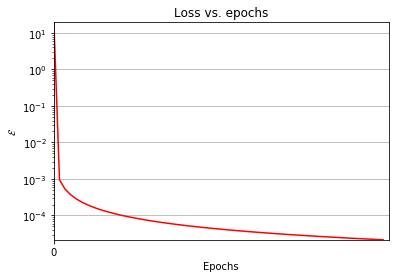

In [110]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(); ax = fig.add_subplot(111)
ax.set_xlim([0,n_epochs]); ax.set_ylim([min(losses), max(losses)]);
ax.set_xticks(epochs[::500]); ax.set_xlabel("Epochs"); ax.grid(True);
ax.set_ylabel(r'$\mathcal{E}$'); 
h1 = ax.semilogy(epochs, losses, 'r-', label=r'$\mathcal{E}$')
plt.title('Loss vs. epochs');

[MNIST data set](http://yann.lecun.com/exdb/mnist/)